### Code for turning our dataset into raster images for inputs in the auxiliary branch

In [25]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import numpy as np

# Load the CSV
data = pd.read_csv(r"C:\Users\chari\Home\TU Delft\TU-Delft\3rd semester\DSAIE\project\CEGM2003-Water\New model\Data\Australia_grid_0p05_data.csv")

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data['lon'], data['lat']),
    crs="EPSG:3577"  # projection of australia
)

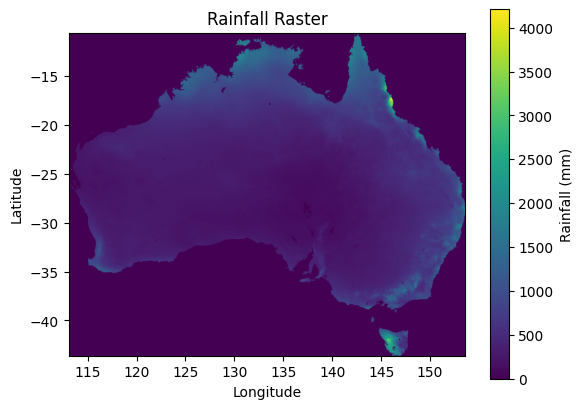

In [26]:

import rasterio
from rasterio.transform import from_origin
from rasterio.features import rasterize
import matplotlib.pyplot as plt


# Define resolution in degrees and calculate grid size
resolution = 0.05  # 0.05 degrees - seen in the file
bounds = gdf.total_bounds  # Get the dataset bounds (minx, miny, maxx, maxy)

# Calculate raster dimensions
width = int((bounds[2] - bounds[0]) / resolution)  # Columns
height = int((bounds[3] - bounds[1]) / resolution)  # Rows

# Create a transform for the raster
transform = from_origin(bounds[0], bounds[3], resolution, resolution)

# Rasterize the data (here rainfall but we can choose whichever quantity from the dataset)
rainfall_raster = rasterize(
    ((geom, value) for geom, value in zip(gdf.geometry, gdf['Rain mm/y'])),
    out_shape=(height, width),
    transform=transform,
    fill=0,  # Default value for no data
    dtype='float32'
)

# Visualize the raster
plt.imshow(rainfall_raster, cmap="viridis", extent=(bounds[0], bounds[2], bounds[1], bounds[3]))
plt.colorbar(label="Rainfall (mm)")
plt.title("Rainfall Raster")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

#Save the raster to GeoTIFF so to be used as the input
meta = {
    'driver': 'GTiff',
    'height': rainfall_raster.shape[0],
    'width': rainfall_raster.shape[1],
    'count': 1,
    'dtype': 'float32',
    'crs': 'EPSG:4326',
    'transform': transform,
}
with rasterio.open("../images_for_CNN/rainfall_raster_0p05deg.tif", 'w', **meta) as dst:
    dst.write(rainfall_raster, 1)


Normalizing and saving the tiff

In [27]:
#normalizing the data to 0-255 (greyscale image pixels')
normalized_data = (rainfall_raster - np.min(rainfall_raster)) / (np.max(rainfall_raster) - np.min(rainfall_raster))
scaled_data = (normalized_data * 255).astype(np.uint8)

# Save the normalized raster
meta.update(dtype='uint8', nodata=0)  # Update metadata for uint8
with rasterio.open("../images_for_CNN/rainfall_raster.tif", "w", **meta) as dst:
    dst.write(scaled_data, 1)

#### Bounded tiff - setting maximum value for precipitation

In [28]:
#here I rescaled the data so that the maxima are more representative and that we can capture more with the pixel resolution

limit = 800 #mm/y
data.loc[data['Rain mm/y'] > limit, 'Rain mm/y'] = limit
# Convert to GeoDataFrame
gdf_rescaled = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data['lon'], data['lat']),
    crs="EPSG:3577"  # projection of australia
)

# Rasterize the data (here rainfall but we can choose whichever quantity from the dataset)
rainfall_raster_rescaled = rasterize(
    ((geom, value) for geom, value in zip(gdf_rescaled.geometry, gdf_rescaled['Rain mm/y'])),
    out_shape=(height, width),
    transform=transform,
    fill=0,  # Default value for no data
    dtype='float32'
)

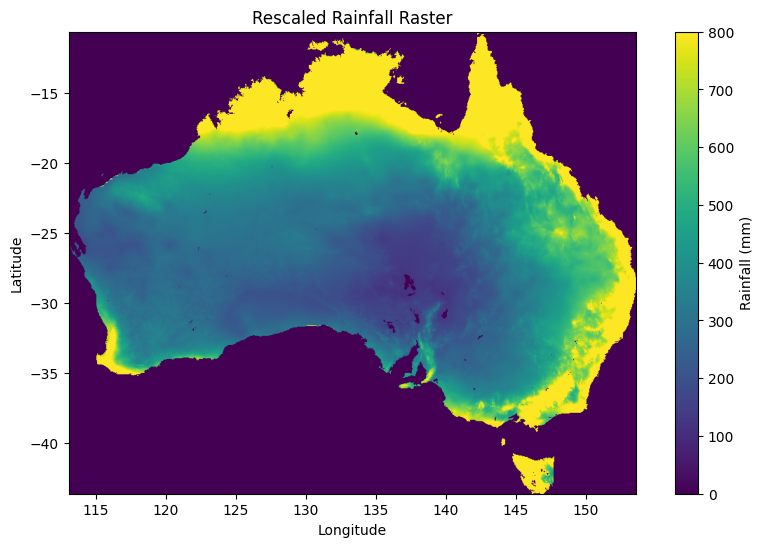

In [29]:
# Plot the rescaled raster
plt.figure(figsize=(10, 6))
plt.imshow(rainfall_raster_rescaled, cmap="viridis", extent=[bounds[0], bounds[2], bounds[1], bounds[3]])
plt.colorbar(label="Rainfall (mm)")
plt.title("Rescaled Rainfall Raster")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [30]:
#normalizing the data to 0-255 (greyscale image pixels')
normalized_data = (rainfall_raster_rescaled - np.min(rainfall_raster_rescaled)) / (np.max(rainfall_raster_rescaled) - np.min(rainfall_raster_rescaled))
scaled_data = (normalized_data * 255).astype(np.uint8)

# Save the normalized raster
meta.update(dtype='uint8', nodata=0)  # Update metadata for uint8
with rasterio.open("../images_for_CNN/rainfall_raster_bound.tif", "w", **meta) as dst:
    dst.write(scaled_data, 1)